# Airbnb Review Analysis

Airbnb is the leading and rapidly growing alternative to the traditional hotel networks. It collects a lot of data about their hosts and their properties, including detailed tourists reviews. In this project, I'm trying to answer these questions;
    1. Are there any significant correlations in the data?
    2. What are the positive and negative reviews?
    3. What features impact the review rating?
    4. Can we predict the the review score?

In [85]:
import random
import string
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import KFold 
from nltk.corpus import names
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

random.seed(21)

%matplotlib inline

## Importing Data

In [2]:
listings  = pd.read_csv('listings.csv')
reviews = pd.read_csv('reviews.csv')
calendar = pd.read_csv('calendar.csv')

In [3]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [4]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [5]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


## Data Wrangling

In [6]:
# Set listing_id as index
reviews.set_index('listing_id', inplace=True)
listings.set_index('id', inplace=True)

# Drop all columns except comments in reviews
reviews.drop(['id', 'date', 'reviewer_id', 'reviewer_name'],
             axis=1, inplace=True)

reviews['comments'] = reviews['comments'].astype(str)
# link the 2 dataset
reviews = pd.merge(listings, reviews, left_index=True, right_index=True)


In [7]:
# Drop all columns that are not comments on new reviews dataframe
other_cols = reviews.columns.values.tolist()
other_cols = [col for col in other_cols if col != 'comments']
reviews.drop(columns=other_cols, axis=1, inplace=True)

# Remove any Null rows
reviews.dropna(inplace=True)
reviews.columns.values

array(['comments'], dtype=object)

In [8]:
reviews.head()

,comments
4291,"We had a great stay in Seattle, great location..."
4291,Greatly enjoyed our quick stay here. We booked...
4291,We had a great experience in Seattle. We enjoy...
4291,"Good room, hosts , and location. Very positive..."
4291,I had a very good experience staying with Jess...


In [9]:
# All comments per listing_id
reviews_series = reviews.groupby(reviews.index)['comments']

# Save indexes to assign to formulated dataframe
rev_idx = reviews.index.values.tolist()
# Make the index unique
rev_idx = list(set(rev_idx))

# Join all comments into a single field for sentiment analysis
rev_cc = reviews_series.agg(lambda col: ' '.join(col))
reviews_cc = pd.DataFrame(rev_cc, index=rev_idx)
reviews_cc.head()

,comments
2727938,Jessica's place was delightfully cozy and clos...
598023,Jeff is a very friendly host. We had the chanc...
794633,"Great space, good location, gracious host. Le..."
958475,"When we arrived at the Annex, everything was a..."
5308429,The place was super chill. I would totally be ...


## Init Sentiment Analyzer

In [10]:
sid = SentimentIntensityAnalyzer()

In [11]:
# Create empty column to populate with the generated sentiment scores
listings['sentiment_score'] = np.nan
# linked comments and places
for i, _ in reviews_cc.iterrows():
    listings.loc[i, 'sentiment_score'] = sid.polarity_scores(reviews_cc['comments'].loc[i])['pos']

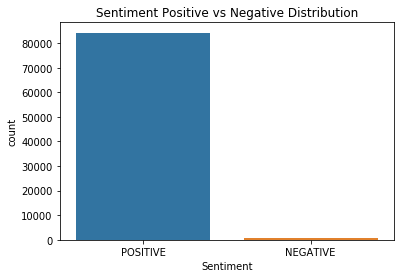

In [12]:
listings.loc[listings.review_scores_rating>=80,'Sentiment']="POSITIVE"
listings.loc[listings.review_scores_rating<80,'Sentiment']="NEGATIVE"

# Merge two datasets
listings_and_reviews = pd.merge(reviews, listings,left_index=True, right_index=True) 
                               

list_of_col1 = ['comments', 'Sentiment']
all_comments = listings_and_reviews[list_of_col1].dropna()

ax = plt.axes()
sns.countplot(all_comments.Sentiment,ax=ax)
ax.set_title('Sentiment Positive vs Negative Distribution')
plt.show()

In [13]:
data = all_comments
print("Number of positive reviews:", len(data[data.Sentiment=="POSITIVE"]))
print("Proportion of positive reviews:", len(data[data.Sentiment=="POSITIVE"])/len(data))
print("Number of negative reviews:", len(data[data.Sentiment=="NEGATIVE"]))
print("Proportion of negative reviews:", len(data[data.Sentiment=="NEGATIVE"])/len(data))

Number of positive reviews: 84220
Proportion of positive reviews: 0.9928208513597944
Number of negative reviews: 609
Proportion of negative reviews: 0.00717914864020559


In [14]:
# Select homes than is "Apartment" and can accommodates 4 customers,
# and meanwhile reviews received per month should no less than 2
listings = listings[listings.property_type == 'Apartment'][listings.reviews_per_month>=2][listings.accommodates == 4]

list_of_col2 = ['review_scores_rating', 'Sentiment']
home_score = listings[list_of_col2]

# merge "homes" table with "reviews" table and select useful columns
homes_and_reviews = pd.merge(reviews, listings, left_index = True, right_index = True)

# Here, we have our first draft experiment data to be used to train model
list_of_col3 = ['comments', 'Sentiment']
home_comments = homes_and_reviews[list_of_col3].dropna()

# Take a subset of the dataset that filters out the reviews with automated postings.
auto = 'The host canceled this reservation | days before arrival | This is an automated posting'
home_comments = home_comments[home_comments.comments.str.contains(auto) == False]

# See the number of reviews that are positive or negative respectively.
home_comments.groupby('Sentiment').size()

/Users/roxanarivkani/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Sentiment
NEGATIVE      41
POSITIVE    6259
dtype: int64

In [15]:
listings.columns.values

array(['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode',
       'market', 'smart_location', 'country_code', 'country', 'latitude',
       'longitude', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'ameni

In [16]:
df = listings[['host_acceptance_rate', 'host_is_superhost',
               'neighbourhood', 'city', 'property_type',
               'room_type', 'accommodates', 'bathrooms', 'bedrooms',
               'beds', 'price', 'guests_included', 'extra_people',
               'minimum_nights', 'maximum_nights', 'review_scores_accuracy', 'review_scores_cleanliness',
               'review_scores_checkin', 'review_scores_communication',
               'review_scores_location', 'review_scores_value', 'review_scores_rating', 
               'instant_bookable', 'cancellation_policy', 'sentiment_score']]

In [17]:
df.describe()

,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,review_scores_rating,sentiment_score
count,133.0,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,133.000000,133.000000
mean,4.0,1.056391,1.135338,1.842105,1.894737,1.857143,734.436090,9.780303,9.666667,9.856061,9.893939,9.727273,9.500000,95.037594,0.290865
std,0.0,0.227421,0.561140,0.561951,0.837232,0.888844,505.712988,0.450858,0.547955,0.352366,0.332870,0.525545,0.545628,4.088798,0.038659
min,4.0,1.000000,0.000000,1.000000,0.000000,1.000000,6.000000,8.000000,8.000000,9.000000,8.000000,7.000000,8.000000,77.000000,0.146000
25%,4.0,1.000000,1.000000,2.000000,1.000000,1.000000,90.000000,10.000000,9.000000,10.000000,10.000000,10.000000,9.000000,93.000000,0.268000
50%,4.0,1.000000,1.000000,2.000000,2.000000,2.000000,1125.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,96.000000,0.297000
75%,4.0,1.000000,1.000000,2.000000,2.000000,2.000000,1125.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,98.000000,0.315000
max,4.0,2.000000,2.000000,4.000000,4.000000,6.000000,1125.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,100.000000,0.381000


In [18]:
# Data types
df.dtypes

host_acceptance_rate            object
host_is_superhost               object
neighbourhood                   object
city                            object
property_type                   object
room_type                       object
accommodates                     int64
bathrooms                      float64
bedrooms                       float64
beds                           float64
price                           object
guests_included                  int64
extra_people                    object
minimum_nights                   int64
maximum_nights                   int64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin          float64
review_scores_communication    float64
review_scores_location         float64
review_scores_value            float64
review_scores_rating           float64
instant_bookable                object
cancellation_policy             object
sentiment_score                float64
dtype: object

In [19]:
# List object columns
object_cols = df.select_dtypes(include=['object']).columns
df[object_cols].head()

,host_acceptance_rate,host_is_superhost,neighbourhood,city,property_type,room_type,price,extra_people,instant_bookable,cancellation_policy
id,,,,,,,,,,
241032,100%,f,Queen Anne,Seattle,Apartment,Entire home/apt,$85.00,$5.00,f,moderate
1686930,100%,f,Queen Anne,Seattle,Apartment,Entire home/apt,$159.00,$0.00,f,strict
7680289,100%,f,Queen Anne,Seattle,Apartment,Entire home/apt,$125.00,$25.00,t,moderate
4218733,100%,f,Queen Anne,Seattle,Apartment,Entire home/apt,$110.00,$15.00,f,moderate
4258515,100%,f,Ballard,Seattle,Apartment,Private room,$47.00,$10.00,f,strict


In [20]:
pd.options.mode.chained_assignment = None

# Adjust object data to numerical
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.rstrip('%').astype('float') / 100.0
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['extra_people'] = df['extra_people'].replace('[\$,]', '', regex=True).astype(float)

# Fill NaN's for acceptance_rate since values are already 1 or 0
df['host_acceptance_rate'].fillna(0, inplace=True)

# Dictionary to map 't' to 1 and 'f' to 0:
map_dict = {'t': 1, 'f': 0}

# List columns to adjust:
bool_cols = ['host_is_superhost', 'instant_bookable']

for col in bool_cols:
    df[col] = df[col].map(map_dict)
    
df[bool_cols].head()

,host_is_superhost,instant_bookable
id,,
241032,0,0
1686930,0,0
7680289,0,1
4218733,0,0
4258515,0,0


In [21]:
df['city'].unique()

array(['Seattle'], dtype=object)

In [22]:
df['neighbourhood'].unique()

array(['Queen Anne', 'Ballard', nan, 'Wallingford', 'Green Lake',
       'Leschi', 'Madrona', 'University District', 'Minor',
       'Pike Place Market', 'Eastlake', 'South Lake Union', 'Belltown',
       'International District', 'Central Business District',
       'First Hill', 'Pioneer Square', 'North Admiral', 'The Junction',
       'Magnolia', 'Greenwood', 'Brighton', 'View Ridge', 'Columbia City',
       'Seward Park', 'Maple Leaf', 'Capitol Hill', 'Stevens',
       'Mathews Beach', 'Roosevelt', 'Lower Queen Anne', 'Fremont',
       'Phinney Ridge', 'Broadview', 'Portage Bay'], dtype=object)

In [23]:
# Clean up city column
df['city'] = df['city'].astype('str')
df['city'] = df['city'].replace('Seattle ', 'Seattle')
df['city'] = df['city'].replace('seattle', 'Seattle')
df['city'] = df['city'].replace('Ballard, Seattle', 'Ballard Seattle')
df['city'] = df['city'].replace('西雅图', 'Seattle')
df['city'].unique()

array(['Seattle'], dtype=object)

In [24]:
# Missing Values & Dummy Columns
object_cols = df.select_dtypes(include=['object']).columns
object_cols

Index(['neighbourhood', 'city', 'property_type', 'room_type',
       'cancellation_policy'],
      dtype='object')

In [25]:
df = pd.get_dummies(df, columns=object_cols, drop_first=True, dummy_na=True)
df.head()

,host_acceptance_rate,host_is_superhost,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights,...,neighbourhood_Wallingford,neighbourhood_nan,city_nan,property_type_nan,room_type_Private room,room_type_Shared room,room_type_nan,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_nan
id,,,,,,,,,,,,,,,,,,,,,
241032,1.0,0,4,1.0,1.0,1.0,85.0,2,5.0,1,...,0,0,0,0,0,0,0,1,0,0
1686930,1.0,0,4,1.0,2.0,2.0,159.0,1,0.0,1,...,0,0,0,0,0,0,0,0,1,0
7680289,1.0,0,4,1.0,1.0,2.0,125.0,2,25.0,2,...,0,0,0,0,0,0,0,1,0,0
4218733,1.0,0,4,1.0,1.0,2.0,110.0,2,15.0,2,...,0,0,0,0,0,0,0,1,0,0
4258515,1.0,0,4,1.0,1.0,4.0,47.0,2,10.0,1,...,0,0,0,0,1,0,0,0,1,0


In [26]:
df.dropna(axis=0, inplace=True)
df.shape

(132, 62)

## Data Analysis

In [27]:
# correlations in the data
# Take a look at the correlation of the original numerical data:

def heatmap_gen(col_list, title_string):
    """
    Displays a heatmap using a range of columns.
    
    Variables:
    col_list - list of columns you want included in the heatmap
    
    Output:
    Seaborn heat map consiting of a range of (lowerbound:higherbound) 
    columns
    """

    corrs = np.corrcoef(df[col_list].values.T)
    sns.set(font_scale=1.2)
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 20)
    ax.title.set_text(title_string)
    hm = sns.heatmap(corrs, cbar = True, 
                     cmap="YlGnBu", annot=True,
                     square = True, fmt = '.2f',
                     yticklabels = col_list,
                     xticklabels = col_list)

/Users/roxanarivkani/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/roxanarivkani/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


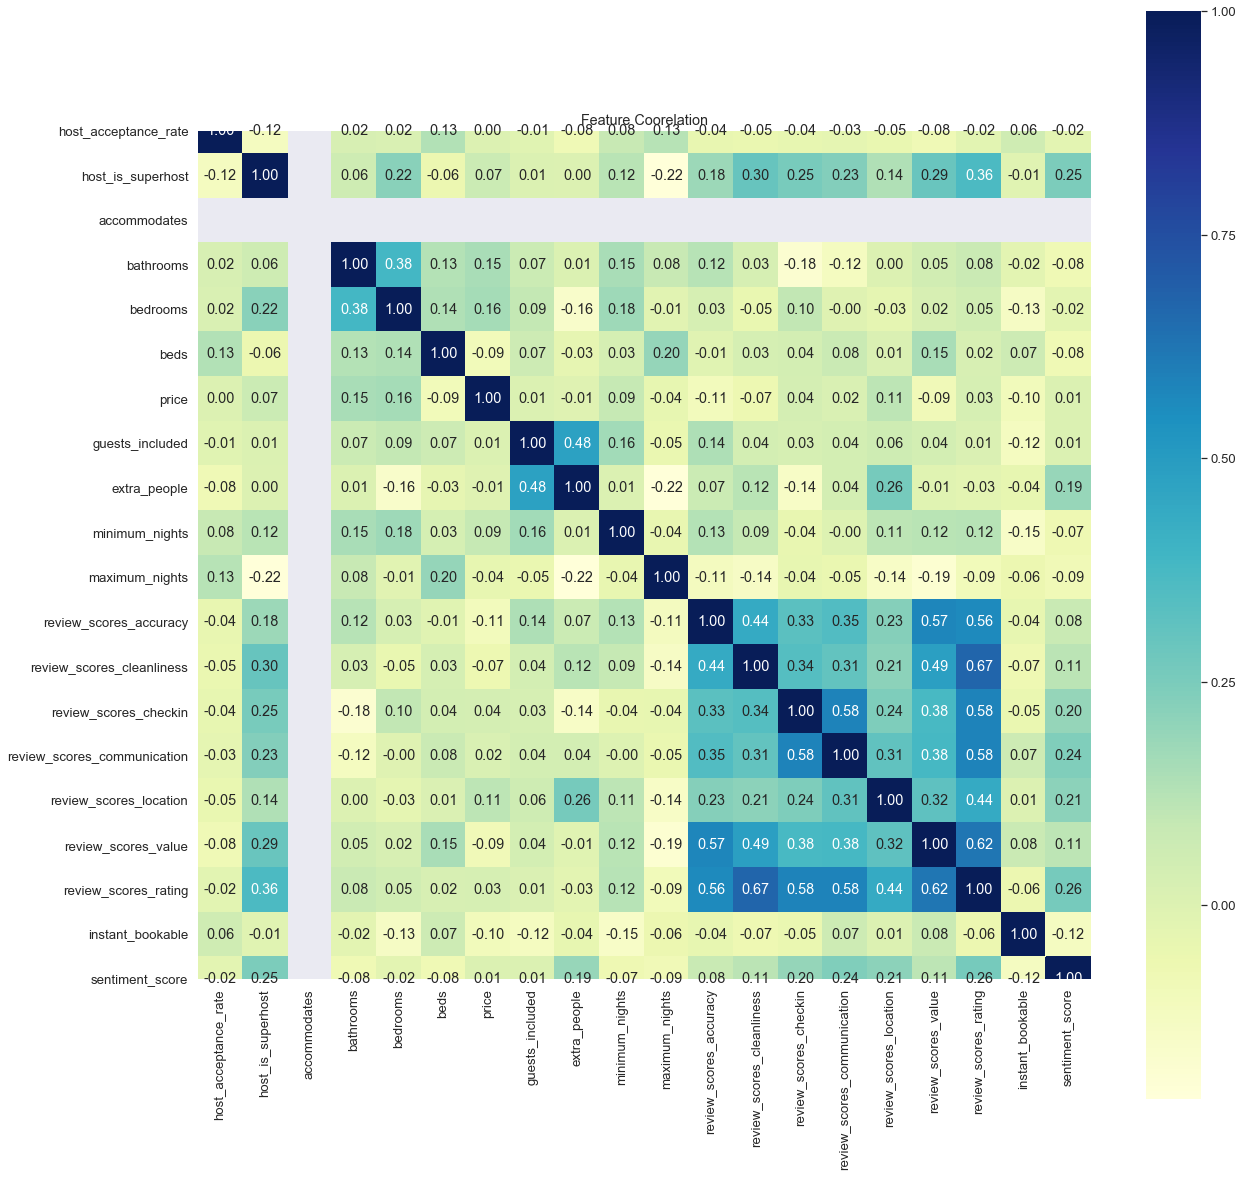

In [28]:
init_cols = df.iloc[:, :20].columns.tolist()
heatmap_gen(init_cols, 'Feature Coorelation')

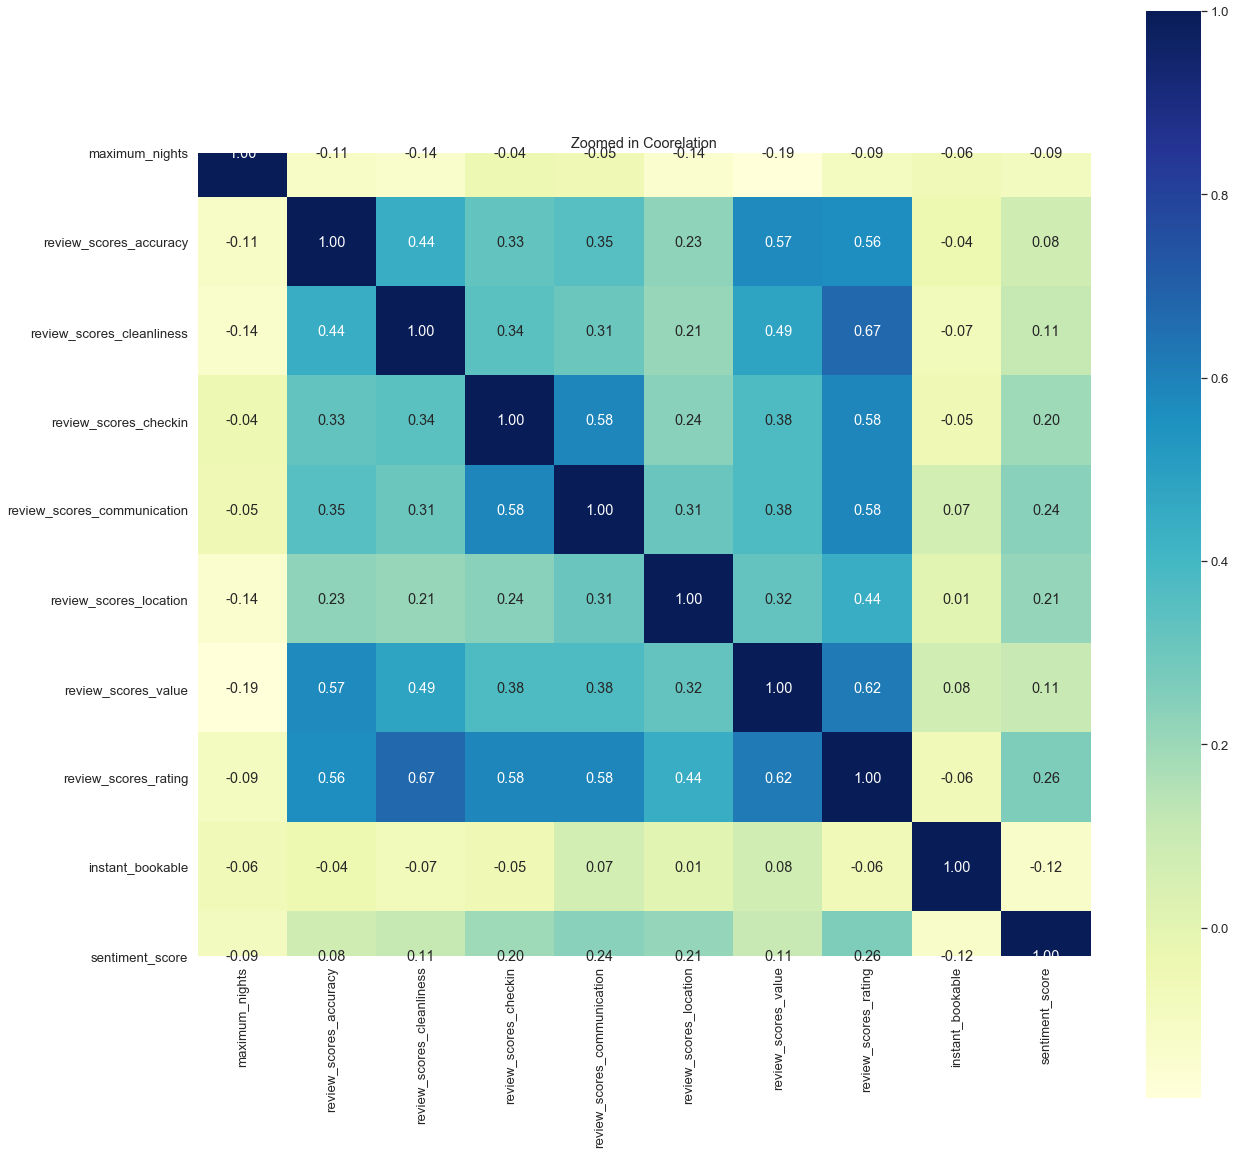

In [29]:
zoomed_cols = df.iloc[:, 10:20].columns.tolist()
heatmap_gen(zoomed_cols, 'Zoomed in Coorelation')

My main focus on this analysis was to distinguish between a good review, bad review and what can be said about both. Also, we are trying to predict the score for the review. So, in order to do so, I had to convert this from a regression problem into a classification problem. Next, I'm going to use another methond to select the important features and then apply those into my prediction model.

In [80]:
# Create a dataframe for feature importance:
feature_importance = pd.DataFrame(rfc.feature_importances_,
                                  index = Xcls,
                                  columns=['Importance Pct.']).sort_values('Importance Pct.',
                                                                           ascending=False)

# Adjust column for readability:
feature_importance['Importance Pct.'] = feature_importance['Importance Pct.']*100
# Keep any feature that attributed to the predictions:
top_features = feature_importance.loc[feature_importance['Importance Pct.'] > 2]

ValueError: Shape of passed values is (2, 1), indices imply (61, 1)

NameError: name 'top_features' is not defined

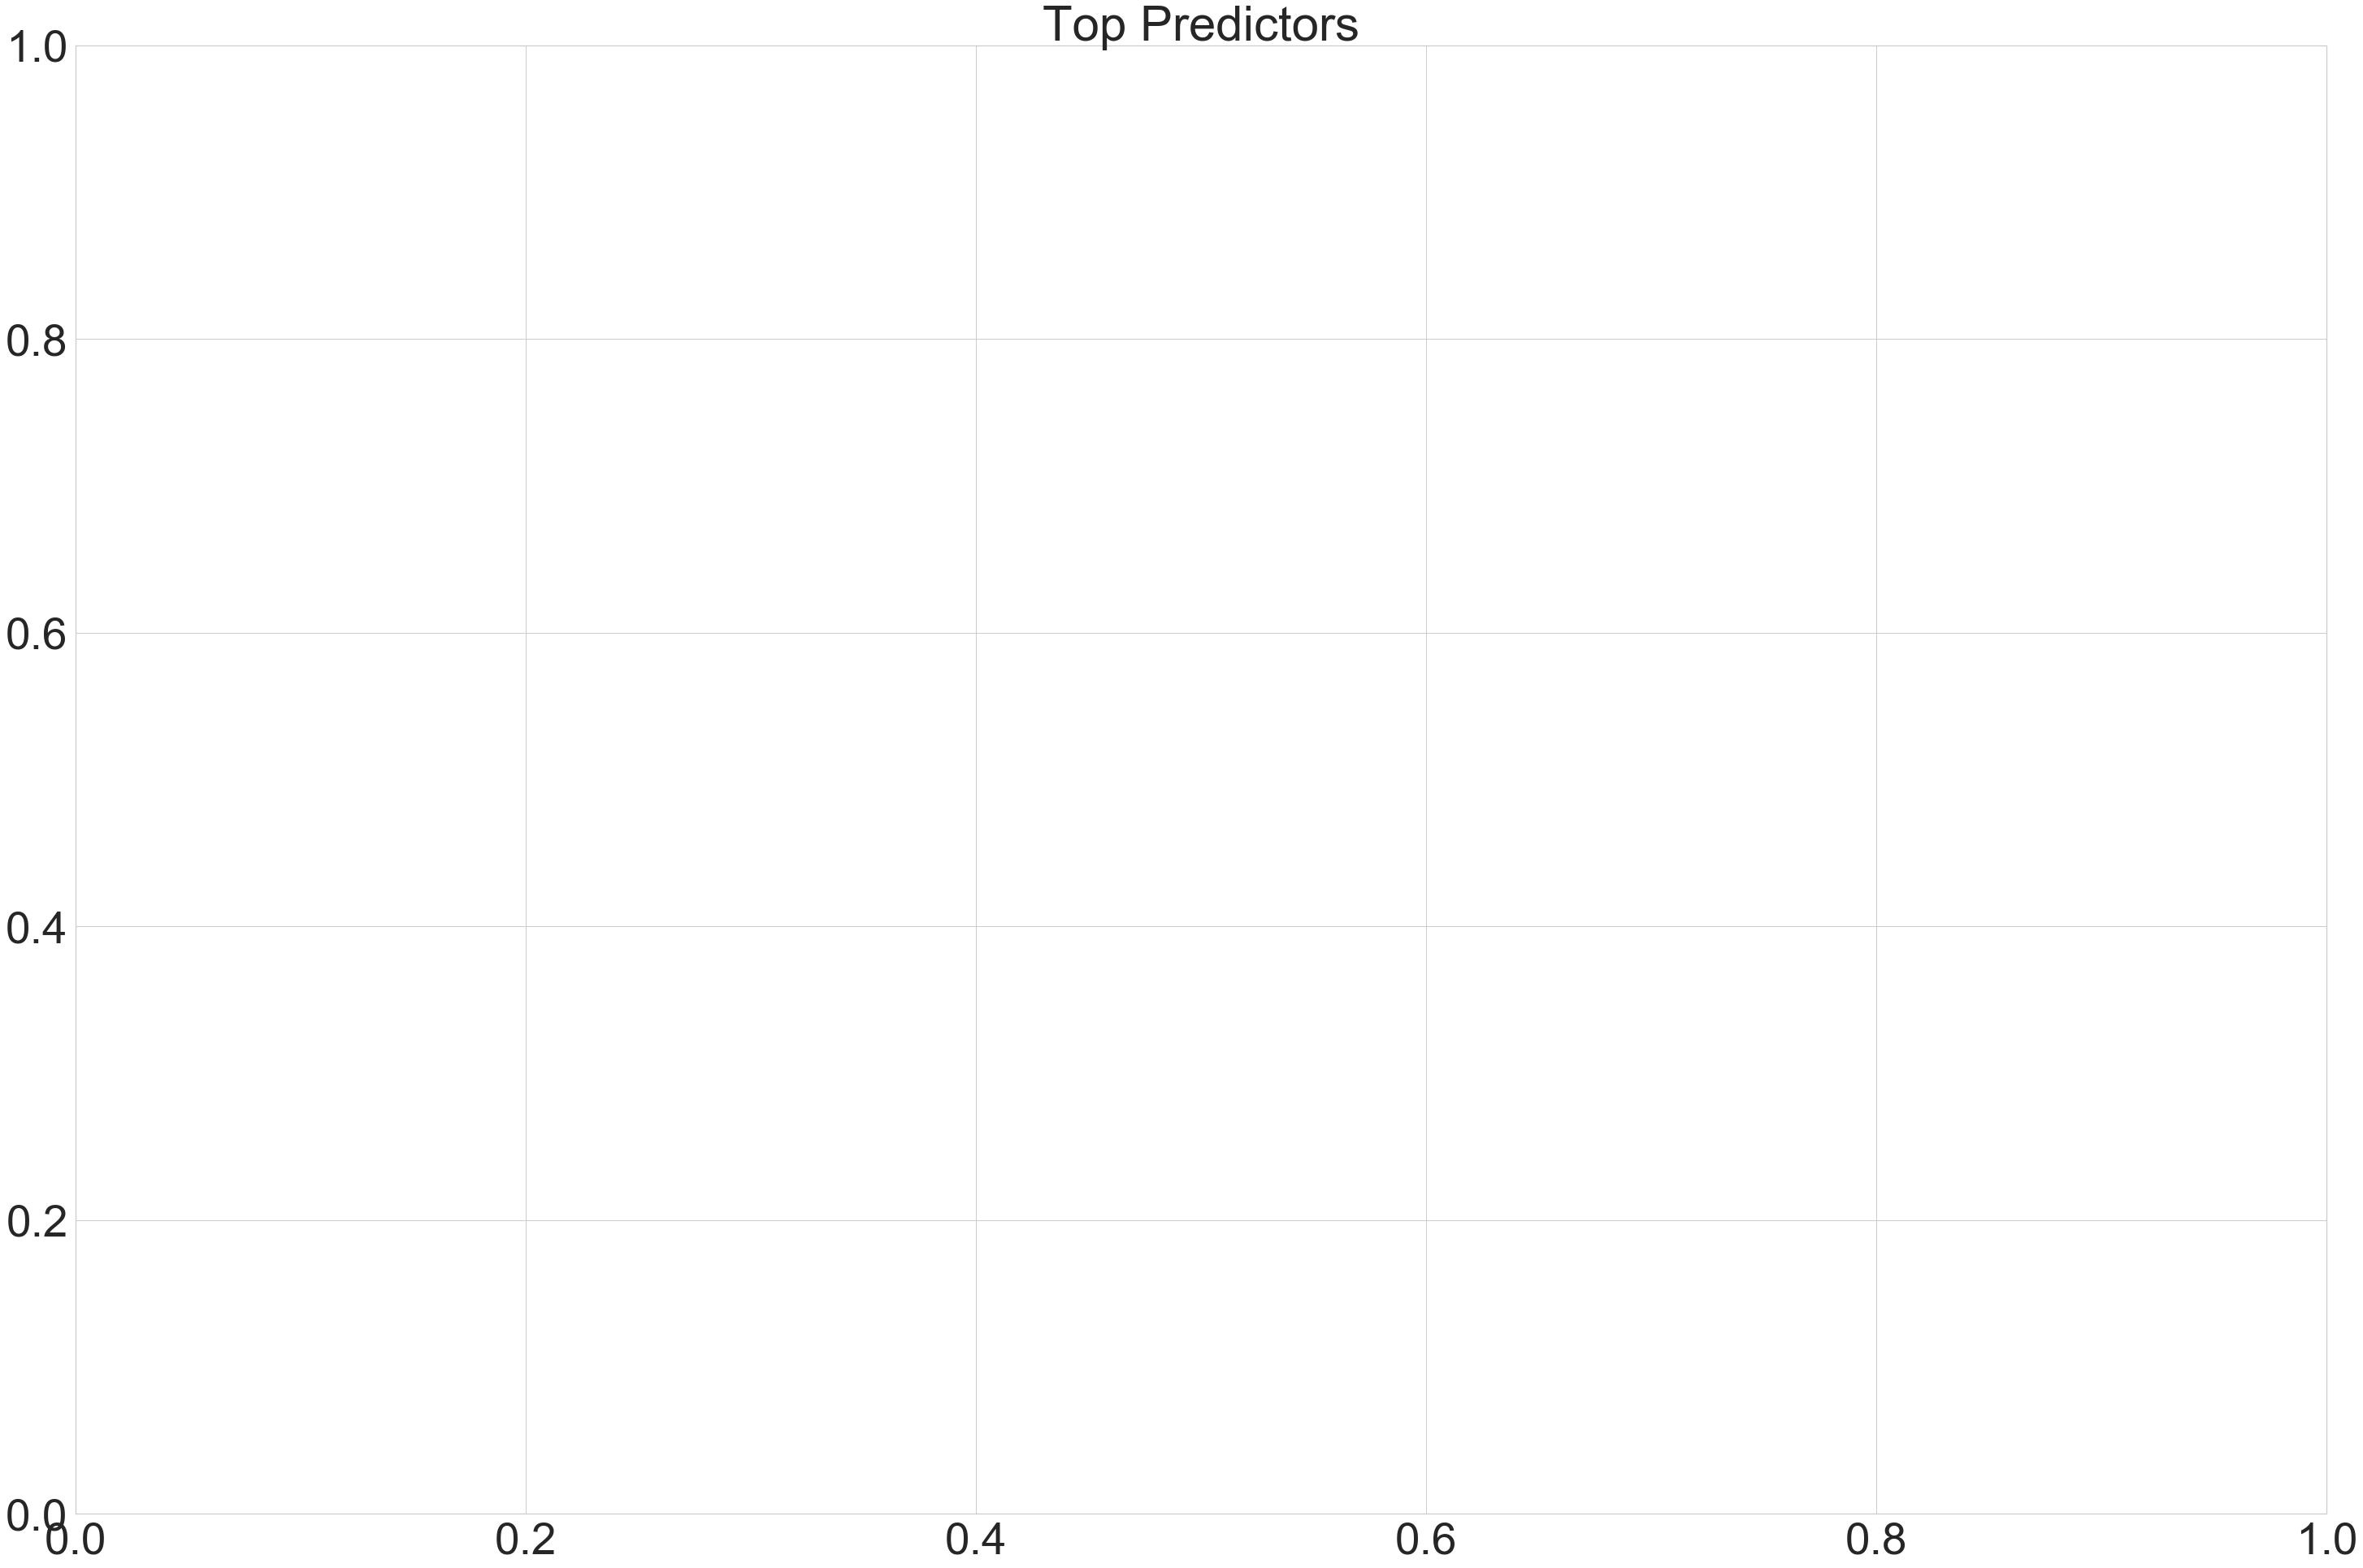

In [81]:
# Visualization:
sns.set(style='whitegrid', font_scale=5)
fig, ax = plt.subplots()
fig.set_size_inches(42, 28)
fig.tight_layout()
ax.title.set_text('Top Predictors')
sns.barplot(x=top_features['Importance Pct.'], 
            y=top_features.index,
            palette='YlGnBu');
plt.show()

Based on the plot, clients are looking for better highest rating score, cleanliness, and accuracy in reviews. Also, in correlations graph we saw the similar resualts.
Overall it looks like customers are looking for a fairly priced, clean and accurate listing with a smooth check in and open communication throughout the stay. All these factors will play into the sentiment and the host being labeled as a superhost.



# What impacted review scores
Get a more in depth perspective on the sentiment of these reviews and compare the differences between the two types.
For the sake of time and computing power, I decided to only pull a random sample of 80% of the comments from the data. This way we get an accurate interpretation of the comments left by customers in a minimal time frame.

Also, to further improve the compute time, we only look at the top ten comments of each listing.
I then use the previously created variables df_top_reviews & df_bottom_reviews to divide the data and generate a word cloud.

My main focus on this analysis was to distinguish between a good review, bad review and what can be said about both. Also, we are trying to predict the score for the review. So, in order to do so, I had to convert this from a regression problem into a classification problem.

    std_dev
    top_pctl
    bottom_pctl
    df_top_reviews
    df_bottom_reviews

In [33]:
# Set baseline for determining success 
avg_rating = df['review_scores_rating'].mean()
avg_rating

95.0

In [34]:
# Get standard deviation to provide more padding for the threshold
std_dev = df['review_scores_rating'].std()

# Create two seperate dataframes based on below threshold
# Which will be used for 'name' and 'description' word analysis.
top_pctl = avg_rating + std_dev/1.75
bottom_pctl = avg_rating - std_dev/1.75
df_top_reviews = df[df['review_scores_rating'] >= top_pctl]
df_bottom_reviews = df[df['review_scores_rating'] <= bottom_pctl]

In [35]:
df['review_scores_rating'] = (df['review_scores_rating'] > avg_rating)* 1
df['review_scores_rating'].head()

id
241032     0
1686930    1
7680289    0
4218733    0
4258515    0
Name: review_scores_rating, dtype: int64

In [36]:
# Split predictor from rest of data:
y = df['review_scores_rating']
X = df.drop('review_scores_rating', axis=1)

In [37]:
pd.options.mode.chained_assignment = None 

# Adjust features to float for scaling:
X = X.astype('float')
y = y.astype('float')

# Save column names for predict importance analysis will focus on highest accuracy scores
Xcls = X.columns

# Scale data with MinMaxScaler 
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [38]:
# Split to train and test data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=21)
print(len(X_train), len(X_test))

88 44


In [39]:
pd.options.mode.chained_assignment = None 

def pred_rev(Xtrn, Xtst, ytrn, ytst):
    """
    RandomForestClassifier predictor.
    
    Variables: 
    Xtrn - Training split from independent features.
    Xtst - Testing split from independent features.
    ytrn - Training split from dependent feature
    ytst - Testing split from dependent feature
    
    Output:
    Accuracy Score of each test, training splits and model.
    """
    # Set algorithm parameters:
    rfc = RandomForestClassifier(bootstrap=True, class_weight=None, 
                                 criterion='gini', max_depth=20, 
                                 max_features='auto', max_leaf_nodes=None,
                                 min_impurity_decrease=0.0, min_impurity_split=None,
                                 min_samples_leaf=4, min_samples_split=5,
                                 min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=8,
                                 oob_score=False, random_state=22, verbose=0, warm_start=False)

    # Fit the data
    rfc.fit(Xtrn, ytrn)

    # Predict:
    train_pred = rfc.predict(Xtrn)
    test_pred = rfc.predict(Xtst)

    # Measure:
    train_acc = accuracy_score(ytrn, train_pred)
    test_acc = accuracy_score(ytst, test_pred)

    
    return train_acc, test_acc, rfc

In [40]:
train_acc, test_acc, rfc = pred_rev(X_train, X_test, y_train, y_test)

print("Predicting Overall Review Rating:")
print("-"*33)
print("\tTrain Accuracy: {:.2%}\n\tTest Accuracy : {:.2%}".format(train_acc, test_acc))

Predicting Overall Review Rating:
---------------------------------
	Train Accuracy: 93.18%
	Test Accuracy : 79.55%


In [109]:
#ignore future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
model = LogisticRegression(solver='lbfgs')
model = LogisticRegression(solver='liblinear')
model = LogisticRegression(solver='lbfgs', multi_class='ovr')
model = LogisticRegression(solver='lbfgs', multi_class='auto')
model = SVC(gamma='auto')
model = SVC(gamma='scale')

from sklearn.model_selection import cross_val_score
# Evaluate Algorithms
models = []
models.append(( 'LR' , LogisticRegression()))
models.append(( 'KNN' , KNeighborsClassifier()))
models.append(( 'CART' , DecisionTreeClassifier()))
models.append(( 'SVM' , SVC()))

                           
# Test options and evaluation metric
num_folds = 10
num_instances = len(X_train)
scoring =  'accuracy'
results = []
names = []
for name, model in models:
    kfold = KFold( n_splits= num_folds, shuffle= False )
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.933333 (0.081650)
KNN: 0.883333 (0.076376)
CART: 0.900000 (0.081650)
SVM: 0.916667 (0.083333)


In [120]:
from sklearn.metrics import precision_recall_fscore_support
for name, model in models:
    model.fit(X_train, y_train)
    print (model)
    res = model.predict(X_test)
    precision,recall,fbeta,_ = precision_recall_fscore_support(y_true = y_test,y_pred=res,average="weighted")
    print("precision:",precision)
    print("recall:",recall)
    print("fbeta:",fbeta)
    print()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
precision: 0.9550000000000001
recall: 0.95
fbeta: 0.9501253132832079

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
precision: 0.9550000000000001
recall: 0.95
fbeta: 0.9501253132832079

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
  

In [117]:
from sklearn.metrics import confusion_matrix
for name, model in models:
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test, y_pred))  

[[18  0]
 [ 2 20]]
[[18  0]
 [ 2 20]]
[[18  0]
 [ 2 20]]
[[18  0]
 [ 2 20]]


In [121]:
# I decided to only pull a random sample of 80% of the comments from the data
# we only look at the top ten comments of each listing
def review_prep(_df, rev):
    idxs = _df.index.values.tolist()
    # rows from the review data
    df_words = rev[rev.index.isin(idxs)].astype('str')
    # Keep only the top 10 reviews from each listing
    gby = df_words.groupby(df_words.index)['comments'].head(10)
    # Create a dataframe
    df_words = pd.DataFrame(gby)
    # Return a randomly select 80% of available comments
    return df_words.sample(frac=.80, random_state=28)

In [43]:
top_rev_words = review_prep(df_top_reviews, reviews)
top_rev_words.head()

,comments
8027776,The help and information Marianne provided was...
4555997,Becky is a great host! She let us borrow a pac...
4165387,We had a wonderful experience. The location is...
8704931,"This place is very nice, cozy, and clean. We w..."
8923774,Molly was a fantastic host! She was so accommo...


In [44]:
# Repeat above for listings:
bot_rev_words = review_prep(df_bottom_reviews, reviews)
bot_rev_words.head()

,comments
6822322,We weren't able to meet Josh but he was availa...
4258515,Lauren and her family were the perfect hosts! ...
6822322,The apartment was very nice in a very nice loc...
3552523,"Gene's place was fantastic! Great location, vi..."
6228959,"At first time, Pj was nice and answer quickly ..."


In [45]:
# Train the model to predic the review score value
B = df['review_scores_value']
A = df.drop('review_scores_value', axis=1)

In [46]:
pd.options.mode.chained_assignment = None 

# Adjust features to float for scaling:
A = A.astype('float')
B = B.astype('float')

# Save column names for predict importance analysis will focus on highest accuracy scores
Acls = A.columns

# Scale data with MinMaxScaler 
scaler = MinMaxScaler()
A = scaler.fit_transform(X)

In [67]:
A.shape

(100, 2)

In [68]:
B.shape

(132,)

In [71]:
# Split to train and test data:
A_train, A_test, B_train, B_test = train_test_split(A, B, test_size = 0.33, random_state=42)
print(len(A_train), len(A_test))

67 33


In [72]:
pd.options.mode.chained_assignment = None 

def pred_rev(Atrn, Atst, Btrn, Btst):
    """
    RandomForestClassifier predictor.
    
    Variables: 
    Xtrn - Training split from independent features.
    Xtst - Testing split from independent features.
    ytrn - Training split from dependent feature
    ytst - Testing split from dependent feature
    
    Output:
    Accuracy Score of each test, training splits and model.
    """
    # Set algorithm parameters:
    rfc = RandomForestClassifier(bootstrap=True, class_weight=None, 
                                 criterion='gini', max_depth=20, 
                                 max_features='auto', max_leaf_nodes=None,
                                 min_impurity_decrease=0.0, min_impurity_split=None,
                                 min_samples_leaf=4, min_samples_split=5,
                                 min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=8,
                                 oob_score=False, random_state=22, verbose=0, warm_start=False)

    # Fit the data
    rfc.fit(Atrn, Btrn)

    # Predict:
    train_pred = rfc.predict(Atrn)
    test_pred = rfc.predict(Atst)

    # Measure:
    train_acc = accuracy_score(Btrn, train_pred)
    test_acc = accuracy_score(Btst, test_pred)

    
    return train_acc, test_acc, rfc

In [73]:
train_acc, test_acc, rfc = pred_rev(A_train, A_test, B_train, B_test)

print("Predicting Overall Review Rating:")
print("-"*33)
print("\tTrain Accuracy: {:.2%}\n\tTest Accuracy : {:.2%}".format(train_acc, test_acc))

Predicting Overall Review Rating:
---------------------------------
	Train Accuracy: 95.52%
	Test Accuracy : 93.94%


In [104]:
#ignore future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
model = LogisticRegression(solver='lbfgs')
model = LogisticRegression(solver='liblinear')
model = LogisticRegression(solver='lbfgs', multi_class='ovr')
model = LogisticRegression(solver='lbfgs', multi_class='auto')
model = SVC(gamma='auto')
model = SVC(gamma='scale')

from sklearn.model_selection import cross_val_score
# Evaluate Algorithms
models = []
models.append(( 'LR' , LogisticRegression()))
models.append(( 'KNN' , KNeighborsClassifier()))
models.append(( 'CART' , DecisionTreeClassifier()))
models.append(( 'SVM' , SVC()))

                           
# Test options and evaluation metric
num_folds = 10
num_instances = len(A_train)
scoring =  'accuracy'
results = []
names = []
for name, model in models:
   
 kfold = KFold( n_splits= num_folds, shuffle= False )
 cv_results = cross_val_score(model, A_train, B_train, cv=kfold, scoring=scoring)
 results.append(cv_results)
 names.append(name)
 msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
 print(msg)

LR: 0.933333 (0.081650)
KNN: 0.883333 (0.076376)
CART: 0.916667 (0.083333)
SVM: 0.916667 (0.083333)


In [125]:
from sklearn.metrics import precision_recall_fscore_support
for name, model in models:
    model.fit(A_train, B_train)
    print (model)
    res = model.predict(A_test)
    precision,recall,fbeta,_ = precision_recall_fscore_support(y_true = B_test,y_pred=res,average="weighted")
    print("precision:",precision)
    print("recall:",recall)
    print("fbeta:",fbeta)
    print()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
precision: 0.9550000000000001
recall: 0.95
fbeta: 0.9501253132832079

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
precision: 0.9550000000000001
recall: 0.95
fbeta: 0.9501253132832079

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
  

In [123]:
from sklearn.metrics import confusion_matrix
for name, model in models:
    B_pred = model.predict(A_test)
    print(confusion_matrix(B_test, B_pred))  

[[18  0]
 [ 2 20]]
[[18  0]
 [ 2 20]]
[[17  1]
 [ 1 21]]
[[18  0]
 [ 2 20]]
